# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [32]:
import time
import itertools
import random
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from modules.utils import Mag
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [3]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, J, gx, gz=0): # gx is transverse field, gz the longitudinal
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [4]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 6 # system size
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [5]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: circ.initialize(init_state, qreg)
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[2:(L+2)]):
#     for i,t in enumerate(thetas[0:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    circ.barrier()
    for i,t in enumerate(thetas[(L+2):]):
#     for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.barrier()
#     circ.ry(thetas[2*L], 4)
#     circ.ry(thetas[2*L+1], 5)
    circ.ry(thetas[0], 4)
    circ.ry(thetas[1], 5)
    circ.barrier()
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    return circ

In [6]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

<ipython-input-5-56433ebd950e>:7: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


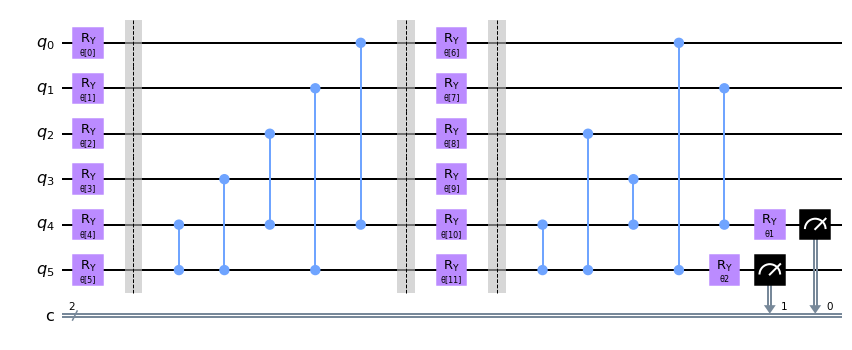

In [7]:
circ = prepare_circuit()
circ.draw('mpl') # trash qubits are at the bottom

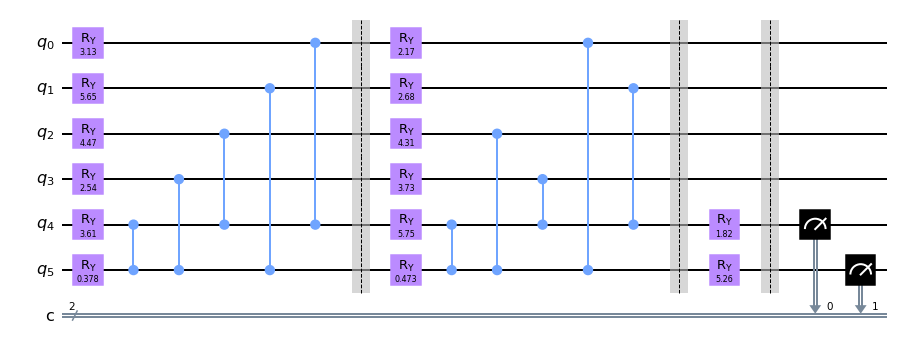

In [8]:
circ = prepare_circuit2(thetas)
# circ = prepare_circuit(feature_encoding(thetas, .6))
circ.draw('mpl') # identical to above

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [9]:
np.random.seed(123)

In [27]:
def run_circuit(thetas, init_state, shots=100000):
    circ = prepare_circuit2(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, seed_simulator=123, seed_transpiler=234)#, memory=True)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
# run_circuit(thetas, init_state)['11']
init_state, E = ising_groundstate(6, 1., 1.6)
run_circuit(thetas, init_state)

{'11': 32250, '10': 10708, '00': 37975, '01': 19067}

In [11]:
def encoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """ full quantum state evolution with encoder part of circuit """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit2(thetas, measurement=False)
    init_state, _ = ising_groundstate(L, J, g, gx)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,range(0,4))
    return traced_state

In [12]:
def encoder_decoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """ full quantum state evolution with encoder & decoder part of circuit """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit2(thetas, measurement=False)
    circ_dagger = circ.inverse()
    
    # encoder part
    init_state, _ = ising_groundstate(L, J, gx, gz)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,[4,5])
    
    # decoder part
    ancilla = np.zeros(4)
    ancilla[0] = 1
    ancilla = qiskit.quantum_info.DensityMatrix(ancilla)
    new_state = traced_state.expand(ancilla)
    final_state = new_state.evolve(circ_dagger)
    fid = qiskit.quantum_info.state_fidelity(Statevector(init_state), final_state)
    return final_state, init_state, fid

In [ ]:
# old version
init_state, E = ising_groundstate(6, 1., 0.0)
circ.initialize(init_state, range(L))
# new_thetas = feature_encoding(thetas, g) # comment out when running w/o feature encoding
new_thetas = thetas
t_qc = transpile(circ, backend=backend_sim, seed_transpiler=234)
qobj = compiler.assemble(t_qc.bind_parameters(new_thetas), backend=backend_sim, seed_simulator=123, shots=100000)
result = backend_sim.run(qobj).result()
out = result.get_counts()
out

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [37]:
#reset random seed
np.random.seed(123)
random.seed(123)

In [43]:
def cost_function_single(thetas, J, gx, gz, shots=1000, param_encoding=False, x=0):
    """ Optimizes circuit """
    init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, init_state, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, ising_params, shots=1000, param_encoding=False, x=0):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        J, gx, gz = p
        if param_encoding: 
            cost += cost_function_single(thetas, J, gx, gz, shots, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, J, gx, gz, shots, param_encoding)
    return cost/n_samples

def optimize(ising_params, thetas=None, shots=1000, max_iter=400, param_encoding=False, x=0):
    np.random.seed(123)
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, ising_params, shots, param_encoding, x)))
    print(thetas)
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    # optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    optimizer = SPSA(maxiter=max_iter,
                     #blocking=True,
                     callback=store_intermediate_result,
                     #learning_rate=1e-1,
                     #perturbation=0.4
                     ) # recommended from qiskit (first iteraction takes quite long)
                       # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, ising_params, shots, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

In [44]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params, max_iter=40)

Initial cost: 44.061
[4.37604495 1.79786647 1.42534972 3.46401286 4.52055686 2.65845629
 6.1623232  4.30291215 3.02178426 2.46374703 2.15625107 4.58075441
 2.75563068 0.37496728]
Time: 0.01435 sec
(array([ 0.21728855,  0.53824052,  0.82570728,  1.53302863,  2.07545661,
        0.37222149,  6.2152577 ,  2.50340851, -0.20705592,  0.99484196,
       -0.48838732,  5.93988765, -0.58319863,  0.23813541]), 20.174832459427535, 120)


In [45]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params, max_iter=40)

Initial cost: 44.061
[4.37604495 1.79786647 1.42534972 3.46401286 4.52055686 2.65845629
 6.1623232  4.30291215 3.02178426 2.46374703 2.15625107 4.58075441
 2.75563068 0.37496728]
Time: 0.01305 sec
(array([ 2.45700374, -1.11119991,  0.0512248 ,  1.10278298,  3.71027384,
       -0.77166865,  5.70714916,  4.68164893,  0.86991084,  1.06766788,
        1.96708972,  2.95085977,  0.78486207, -1.01239337]), 22.455211783384186, 120)


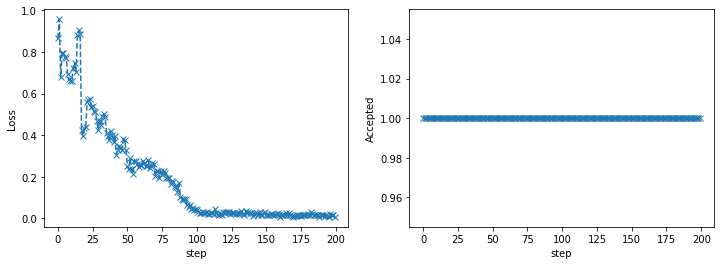

In [26]:
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
# plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accepted, "x--")
plt.xlabel("step")
plt.ylabel("Accepted");

## Trying stuff out

### Train with two different states from each normal "fake phase"

In [29]:
Js = [-1]*2
gxs = [0.1,10]
gzs = [10,0.1]
params = list(zip(Js, gxs, gzs))
thetas, loss, accepted = optimize(params)
thetas_normal_phase = thetas

Initial cost: 0.851
Time: 132.75038 sec
(array([ 2.705732  ,  3.57364501,  4.67385761,  1.56939475,  1.70944411,
        4.79670972,  2.52491677,  5.65438724, -0.02406072,  6.25960497,
        3.45731662,  2.98496779,  0.14782258,  2.98113575]), 0.1795, 1200)


In [169]:
thetas = thetas_normal_phase

In [1]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

NameError: name 'plt' is not defined

In [98]:
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)
        init_state, _ = ising_groundstate(5, J, gx, gz)
        Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state

<ipython-input-98-4984e46c0766>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state


<ipython-input-99-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-99-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


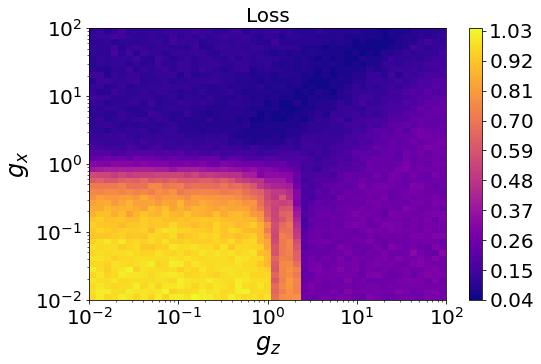

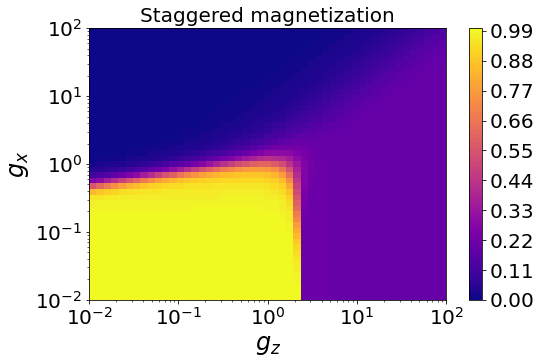

In [99]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [170]:
J = -1
gxs = np.logspace(-2, 2, 50)
gz = .01
cost1, Smags1, Smags12 = [], [], []
shots = 10000
Ll = 5
for gx in gxs:
    cost1.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags1.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags12.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
gzs = np.logspace(-2, 2, 50)
gx = .01
cost2, Smags2, Smags22 = [], [], []
for gz in gzs:
    cost2.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags2.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags22.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))

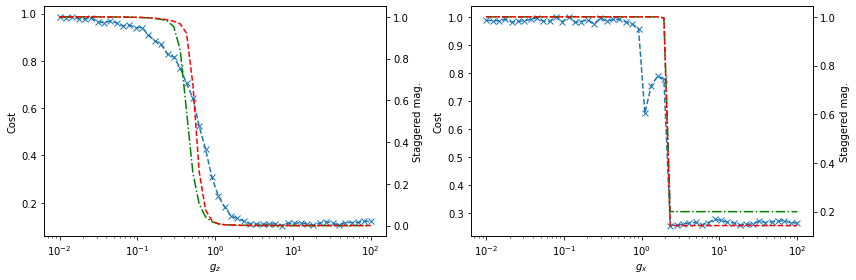

In [171]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
ax4 = ax3.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Cost")
ax1.plot(gzs, cost1, "x--")
ax2.plot(gzs, Smags1, "g-.")
ax2.plot(gzs, Smags12, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Cost")
ax3.plot(gzs, cost2, "x--")
ax4.plot(gzs, Smags2, "g-.")
ax4.plot(gzs, Smags22, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")
fig.tight_layout()

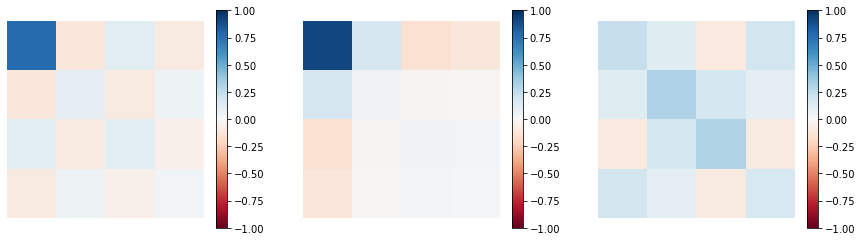

In [36]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
J, g, gx = -1., .1, 10.
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 2)
J, g, gx = -1., 10., .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 3)
J, g, gx = -1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|, the first two images are the ones for which circuit was optimized

To double check I am now looking at the ferromagnetic side of the phase diagram (the circuit hasn't been trained on any of these states), but we can still see a phase diagram and with a bit of imagination the phase transition is reduced to a critical point (at gx = 1).

In [441]:
points = 50
J = 1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)

<ipython-input-442-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


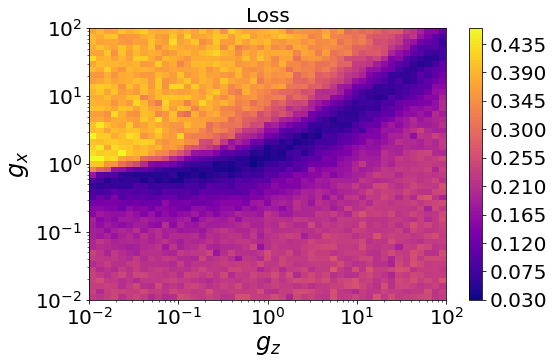

In [442]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

And as a final sanity check I am using random (not optimized) circuit paramaters. Actually you can still recover the phase diagram somehow (at least for the few random values I checked), but the differences in the loss function are not so big anymore.

In [27]:
np.random.seed(123)
thetas_random = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas_random, J, gx, gz, shots=shots)

<ipython-input-474-6c028b1c1a58>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)


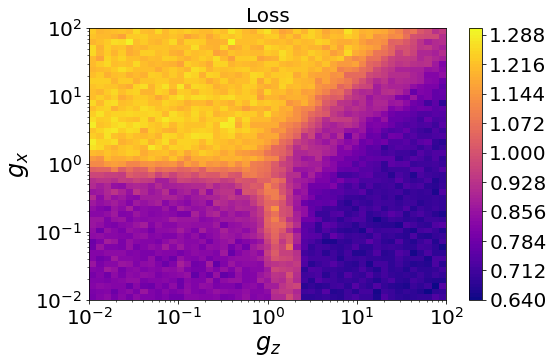

In [474]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

### Train with single state from the odered phase

In [112]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params)
thetas_ordered_phase = thetas

Initial cost: 0.946
Time: 72.57137 sec
(array([ 6.28637848, -1.56383044,  6.29485363,  7.8432408 ,  3.1115518 ,
        4.70478804,  1.57411268,  6.28552164,  1.57387168,  2.24379343,
        1.59200026,  7.46993774, -1.61006261,  3.16035161]), 0.008, 1200)


In [172]:
thetas = thetas_ordered_phase

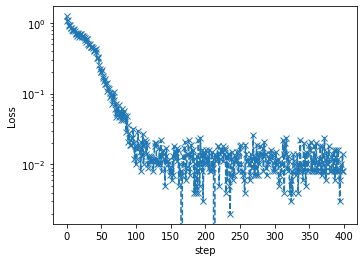

In [116]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss");

In [115]:
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)
        init_state, _ = ising_groundstate(5, J, gx, gz)
        Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state

<ipython-input-115-4984e46c0766>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state


<ipython-input-117-2a3c55111b87>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
<ipython-input-117-2a3c55111b87>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)


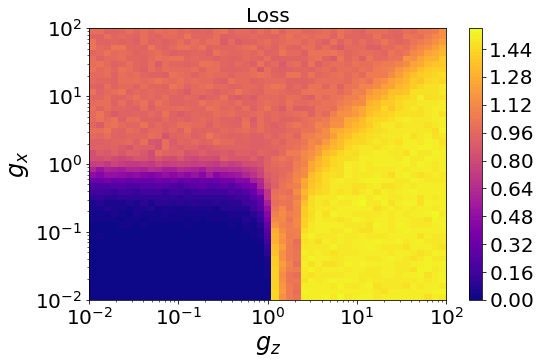

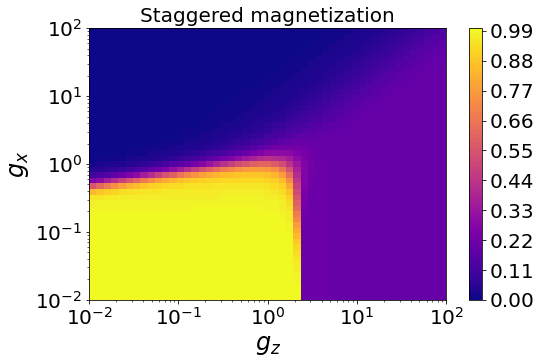

In [117]:
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

In [173]:
J = -1
gxs = np.logspace(-2, 2, 50)
gz = .01
cost1, Smags1, Smags12 = [], [], []
shots = 10000
Ll = 5
for gx in gxs:
    cost1.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags1.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags12.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
gzs = np.logspace(-2, 2, 50)
gx = .01
cost2, Smags2, Smags22 = [], [], []
for gz in gzs:
    cost2.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags2.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags22.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
Js = np.linspace(-10, 10, 50)
gx = 0.1
gz = 0.1
cost3, Smags3, Smags32 = [], [], []
for J in Js:
    cost3.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags3.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags32.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))

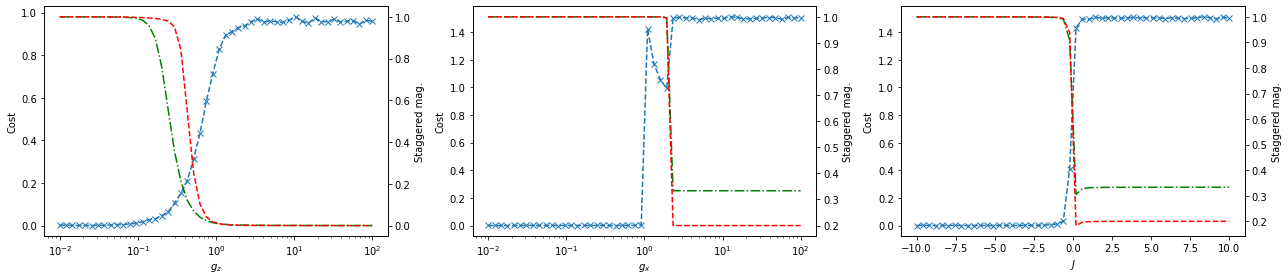

In [161]:
fig = plt.figure(figsize=(18,4))
ax1 = plt.subplot(131)
ax2 = ax1.twinx()
ax3 = plt.subplot(132)
ax4 = ax3.twinx()
ax5 = plt.subplot(133)
ax6 = ax5.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Cost")
ax1.plot(gzs, cost1, "x--")
ax2.plot(gzs, Smags1, "g-.")
ax2.plot(gzs, Smags12, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Cost")
ax3.plot(gzs, cost2, "x--")
ax4.plot(gzs, Smags2, "g-.")
ax4.plot(gzs, Smags22, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")

ax5.set_xlabel(r"$J$")
ax5.set_ylabel("Cost")
ax5.plot(Js, cost3, "x--")
ax6.plot(Js, Smags3, "g-.")
ax6.plot(Js, Smags32, "r--")
ax6.set_ylabel("Staggered mag.")
fig.tight_layout();

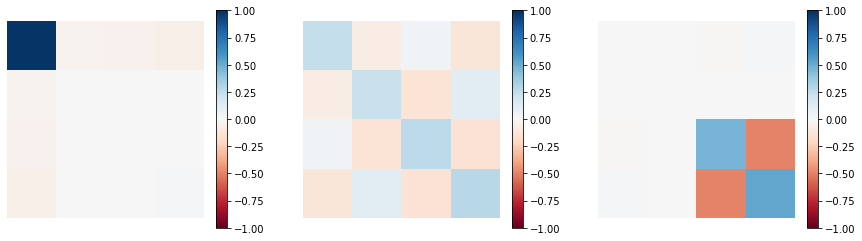

In [489]:
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
J, g, gx = -1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 2)
J, g, gx = -1., 2., 2.
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(1, 3, 3)
J, g, gx = 1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|, the first image is the one for which circuit was optimized

Compute fidelity of input and final state after it has been compressed and decompressed.

In [124]:
J, gx, gz = -1., .1, .1
gzs = np.logspace(-2, 2, 50)
fid1 = []
for gz in gzs:
    fid1.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])
    
J, gx, gz = -1., .1, .1
gxs = np.logspace(-2, 2, 50)
fid2 = []
for gx in gxs:
    fid2.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])
    
J, gx, gz = -1., .1, .1
Js = np.linspace(-10, 10, 50)
fid3 = []
for J in Js:
    fid3.append(encoder_decoder_evolv(thetas, J, gx, gz)[2])

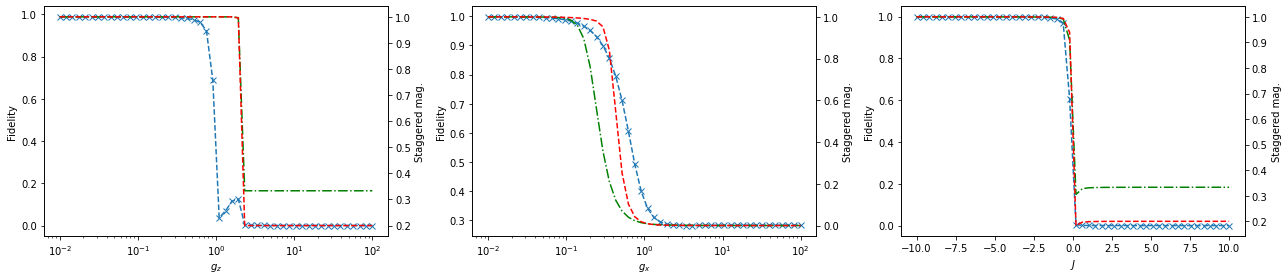

In [162]:
fig = plt.figure(figsize=(18,4))
ax1 = plt.subplot(131)
ax2 = ax1.twinx()
ax3 = plt.subplot(132)
ax4 = ax3.twinx()
ax5 = plt.subplot(133)
ax6 = ax5.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Fidelity")
ax1.plot(gzs, fid1, "x--")
ax2.plot(gzs, Smags2, "g-.")
ax2.plot(gzs, Smags22, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Fidelity")
ax3.plot(gzs, fid2, "x--")
ax4.plot(gzs, Smags1, "g-.")
ax4.plot(gzs, Smags12, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")

ax5.set_xlabel(r"$J$")
ax5.set_ylabel("Fidelity")
ax5.plot(Js, fid3, "x--")
ax6.plot(Js, Smags3, "g-.")
ax6.plot(Js, Smags32, "r--")
ax6.set_ylabel("Staggered mag.")
fig.tight_layout();

Same as above but using random circuit (not optimized)

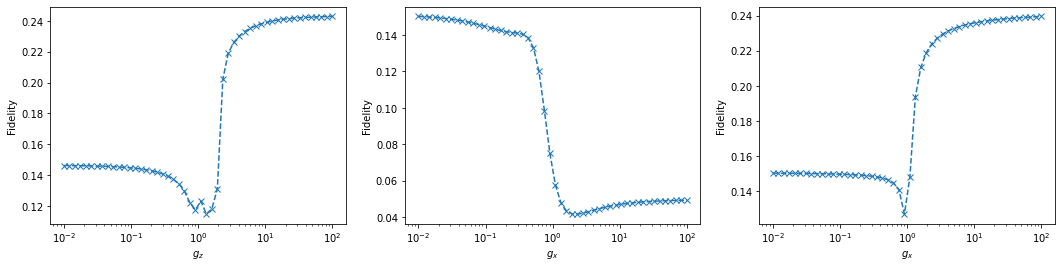

In [29]:
fig = plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(gzs, fid1, "x--")
plt.xscale("log")
plt.xlabel(r"$g_z$")
plt.ylabel("Fidelity");

plt.subplot(1, 3, 2)
plt.plot(gxs, fid2, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Fidelity");

plt.subplot(1, 3, 3)
plt.plot(gxs, fid3, "x--")
plt.xscale("log")
plt.xlabel(r"$g_x$")
plt.ylabel("Fidelity");

### Train with feature encoding

When using feature encoding one has to train considerably longer and the results are still not great.

In [75]:
# with feature encoding
Js = [1.0]
gxs = np.linspace(0.1, 0.6, 10)
gzs = [0.01]
a = [Js, gxs, gzs]
params = list(itertools.product(*a))
thetas, loss, accepted = optimize(params, max_iter=1000, param_encoding=True, x=gxs)
thetas2 = thetas

Initial cost: 0.989
Time: 1463.28618 sec
(array([1.37695394, 2.67715853, 5.00584083, 3.34898427, 5.64009225,
       2.23703174, 2.18902995, 5.78050043, 7.10197656, 0.53668601,
       1.67204281, 2.72165781, 0.71795249, 2.69861899, 1.558868  ,
       1.8060758 , 6.32325627, 2.32631895, 1.70878547, 3.85464599,
       4.50585028, 1.41635192, 5.43113159, 6.19587763, 0.96844201,
       5.94268829, 2.8961255 , 1.37497256]), 0.064, 3000)


In [52]:
# without feature encoding
Js = [1.0]
gxs = np.linspace(0.1, 0.6, 10)
gzs = [0.01]
a = [Js, gxs, gzs]
params = list(itertools.product(*a))
thetas, loss2, accepted = optimize(params, max_iter=200, param_encoding=False)
thetas3 = thetas

Initial cost: 0.543
Time: 290.26000 sec
(array([ 0.03922362,  6.29084145,  1.50309192,  3.95811563,  4.53126754,
        3.33244368, -0.20014478,  5.90938738,  5.74557653,  1.39299094,
        1.09336045,  3.09511845,  6.2456063 ,  6.31633132]), 0.028000000000000004, 600)


Text(0, 0.5, 'Loss')

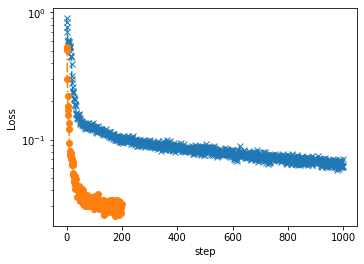

In [77]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.plot(loss2, "o-.")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss")

In [78]:
J = 1.
gxs = np.linspace(0.01, 1.2, 50)
gz = .01
cost1, cost2 = [], []
shots = 10000
param_encoding=False
for gx in gxs:
    cost1.append(cost_function_single(thetas2, J, gx, gz, shots=shots, param_encoding=True, x=gx))
    cost2.append(cost_function_single(thetas3, J, gx, gz, shots=shots, param_encoding=False, x=gx))

Text(0, 0.5, 'Cost')

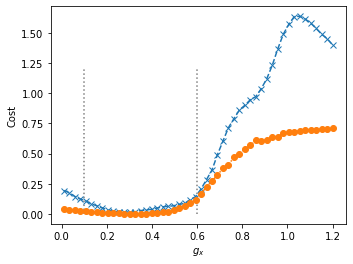

In [79]:
fig = plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.plot(gxs, cost1, "x--")
plt.plot(gxs, cost2, "o-.")
# plt.xscale("log")
plt.vlines(0.6, 0, 1.2, colors="tab:gray", linestyles='dotted')
plt.vlines(0.1, 0, 1.2, colors="tab:gray", linestyles='dotted')
plt.xlabel(r"$g_x$")
plt.ylabel("Cost")

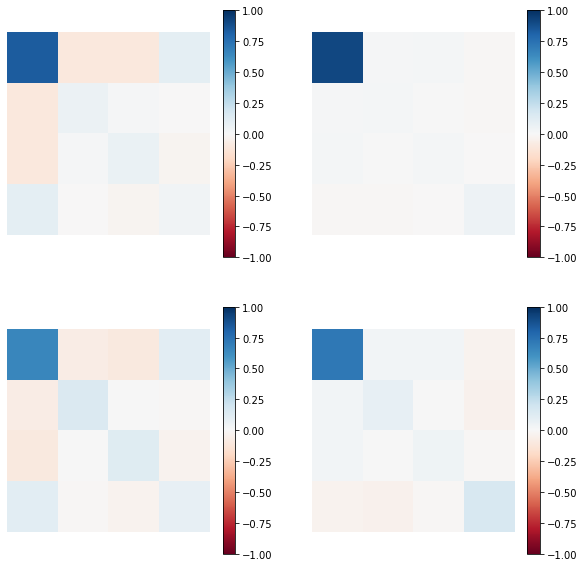

In [80]:
fig = plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1)
J, g, gx = 1., .6, .01
traced_state = encoder_evolv(thetas2, J, gx, gz, param_encoding=True, x=gx)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(2, 2, 2)
J, g, gx = 1., .6, .01
traced_state = encoder_evolv(thetas3, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(2, 2, 3)
J, g, gx = 1., .75, .01
traced_state = encoder_evolv(thetas2, J, gx, gz, param_encoding=True, x=gx)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');

plt.subplot(2, 2, 4)
J, g, gx = 1., .75, .01
traced_state = encoder_evolv(thetas3, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# same as Fig. 5